<a href="https://colab.research.google.com/github/alvinmhabieb/Portfolio/blob/main/Tour_%26_Travels_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The key indicators of customer churn were age, frequent flyer status and income class. Specifically,

younger customers (27-28y) tend to churn proportionally more often
frequent flyers churn more than non-frequent flyers
high income individuals churn more than low and middle income classes
Of the compared models, the balanced bagging classifier performed best in order to predict customer churn. It performed with an overall accuracy of 90%, as well as an F1 score 81 and other performance metrics >70 for the minority class. Given that it may be most important to correctly identify those customers who churn, the priority is to predict the minority class correctly. Thus, using a classifier focusing on balancing the data set and therefore boosting performance to identify those customers who churn, so they can be in focus of measures to improve customer satisfaction.

# Import Libraries

In [1]:
!pip install skope-rules
!pip install eli5
!pip install scikit-plot
!pip install shap
!pip install lime
!pip install dalex
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.0 MB/s 
     |████████████████████████████████| 133 kB 40.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=e2bc63fe2ecfd435f9ce5fe6262d5a777938fe8e1ec646d045f56366a0d65cad
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which 

In [2]:
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
palette = {0: 'tab:blue',1: 'tab:orange'}

import plotly.express as px
import pickle
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import *
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
import sklearn.metrics as metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import *
from sklearn import svm,tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn import model_selection

# load rulefit model
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from yellowbrick.classifier import DiscriminationThreshold 

# load scikit-plot modules
import scikitplot as skplt

# load shap package for shap explanation
import shap

# load eli5
import eli5

# load LimeTabularExplainer for LIME method
from lime.lime_tabular import LimeTabularExplainer 

# import dalex to explain complex model
import dalex as dx

# for Q-Q plots
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from scipy.stats import chi2_contingency

import os, random
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

# Data Inspection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/Customertravel.csv')

In [5]:
data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0
...,...,...,...,...,...,...,...
949,31,Yes,Low Income,1,No,No,0
950,30,No,Middle Income,5,No,Yes,0
951,37,No,Middle Income,4,No,No,0
952,30,No,Low Income,1,Yes,Yes,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


In [7]:
columns_name =[]
unique_value=[]
# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        columns_name.append(str(col)) 
        unique_value.append(data[col].nunique())
table= pd.DataFrame()
table['Columns'] = columns_name
table['Unique']= unique_value
            
table=table.sort_values('Unique',ascending=False)
table

,Columns,Unique
0,FrequentFlyer,3
1,AnnualIncomeClass,3
2,AccountSyncedToSocialMedia,2
3,BookedHotelOrNot,2


In [8]:
# extracting categorical columns
cat = data.select_dtypes(include = ['object'])

# printing unique values of each column
for col in cat.columns:
    print(f"{col}: \n{cat[col].unique()}\n")

FrequentFlyer: 
['No' 'Yes' 'No Record']

AnnualIncomeClass: 
['Middle Income' 'Low Income' 'High Income']

AccountSyncedToSocialMedia: 
['No' 'Yes']

BookedHotelOrNot: 
['Yes' 'No']



# Data Preparation

### Missing Values Handling

In [9]:
data.isnull().sum()

Age                           0
FrequentFlyer                 0
AnnualIncomeClass             0
ServicesOpted                 0
AccountSyncedToSocialMedia    0
BookedHotelOrNot              0
Target                        0
dtype: int64

In [10]:
# Data Profilling
print("="*10,"Data Profilling","="*10)

# Data Shape
print("Data shape :", data.shape)
print("")

# Data Info
print("Data info :")
print(data.info())
print("")

# Data duplication
print("Data duplication :")
print(data.duplicated().sum())
print("")

========== Data Profilling ==========
Data shape : (954, 7)

Data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB
None

Data duplication :
507



### Data Transformation

In [11]:
# Change Definition
data['Target'] = data['Target'].replace({0:'Retain', 1:'Churn'})

In [12]:
data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,Retain
1,34,Yes,Low Income,5,Yes,No,Churn
2,37,No,Middle Income,3,Yes,No,Retain
3,30,No,Middle Income,2,No,No,Retain
4,30,No,Low Income,1,No,No,Retain
...,...,...,...,...,...,...,...
949,31,Yes,Low Income,1,No,No,Retain
950,30,No,Middle Income,5,No,Yes,Retain
951,37,No,Middle Income,4,No,No,Retain
952,30,No,Low Income,1,Yes,Yes,Retain


##  Data Correlation

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,954.0,32.109015,3.337388,27.0,30.0,31.0,35.0,38.0
ServicesOpted,954.0,2.437107,1.606233,1.0,1.0,2.0,4.0,6.0


### Correlation between Quantitative Variables

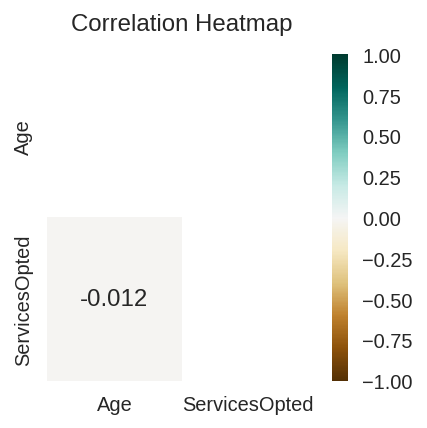

In [14]:
# Increase the size of the heatmap
plt.figure(figsize=(3,3))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Correlation between Qualitative Variables

In [15]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    
    try:
        chi2 = chi2_contingency(contingency_table)[0]
    except ValueError:
        return np.NaN
    
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [16]:
def categorical_corr_matrix(data):
    """
        Computes corrected Cramer's V statistic between all the
        categorical variables in the dataframe
    """
    data = data.select_dtypes(include='object')
    cols = data.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    excluded_cols = list()
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            data_crosstab = pd.crosstab(data[col1], data[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(data_crosstab)
                
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

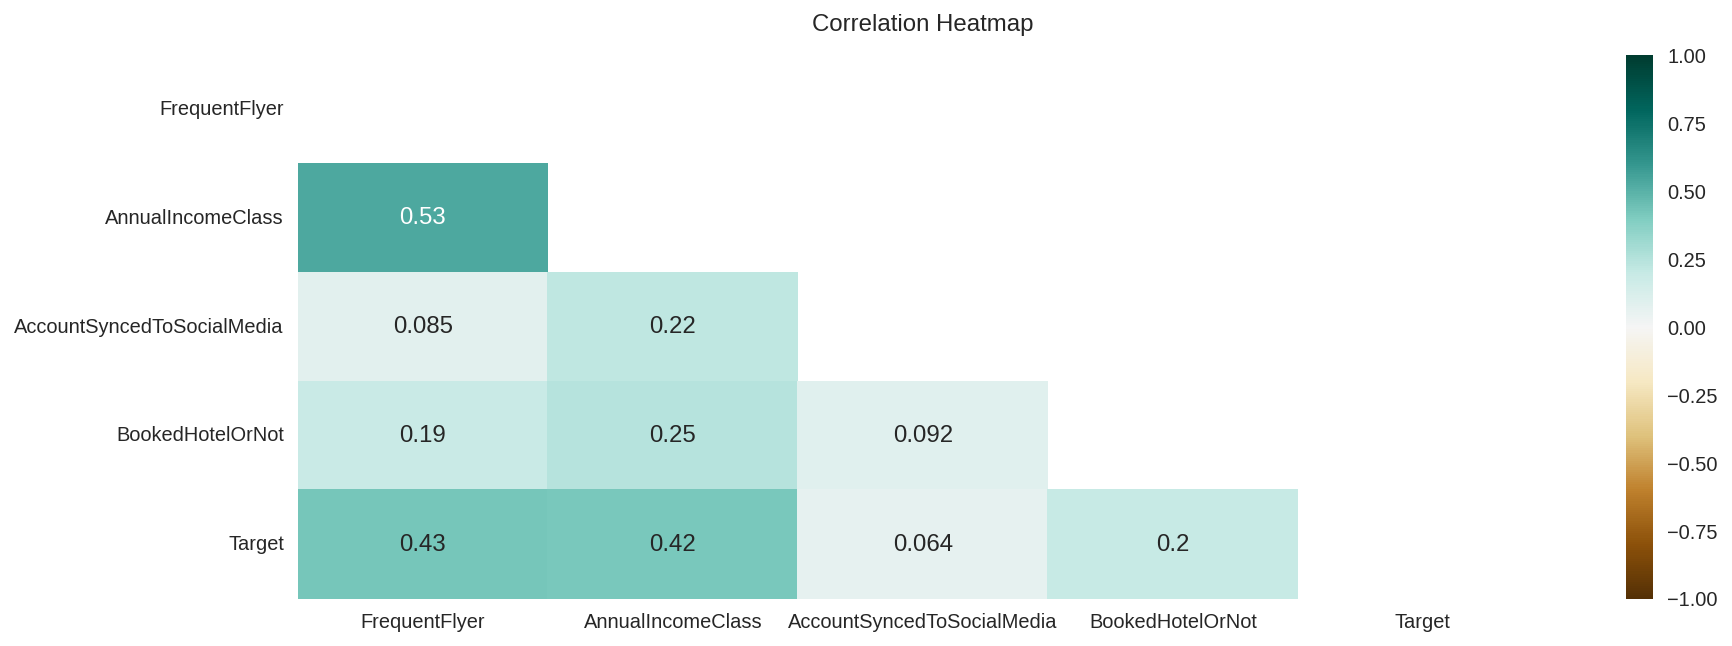

In [17]:
# Increase the size of the heatmap
plt.figure(figsize=(14,5))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(categorical_corr_matrix(data), dtype=np.bool))
heatmap = sns.heatmap(categorical_corr_matrix(data), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Exploratory Data Analysis

## Targeting Variable

In [18]:
Target = data['Target'].value_counts()

fig = px.pie(Target, 
             values = Target.values, 
             names = Target.index)
fig.update_traces(textposition='inside', textinfo='percent+label+value', 
                  marker = dict(line = dict(color = 'white', width = 1)))
fig.show(figsize=(3,3))

## Categorical Variables by Churn

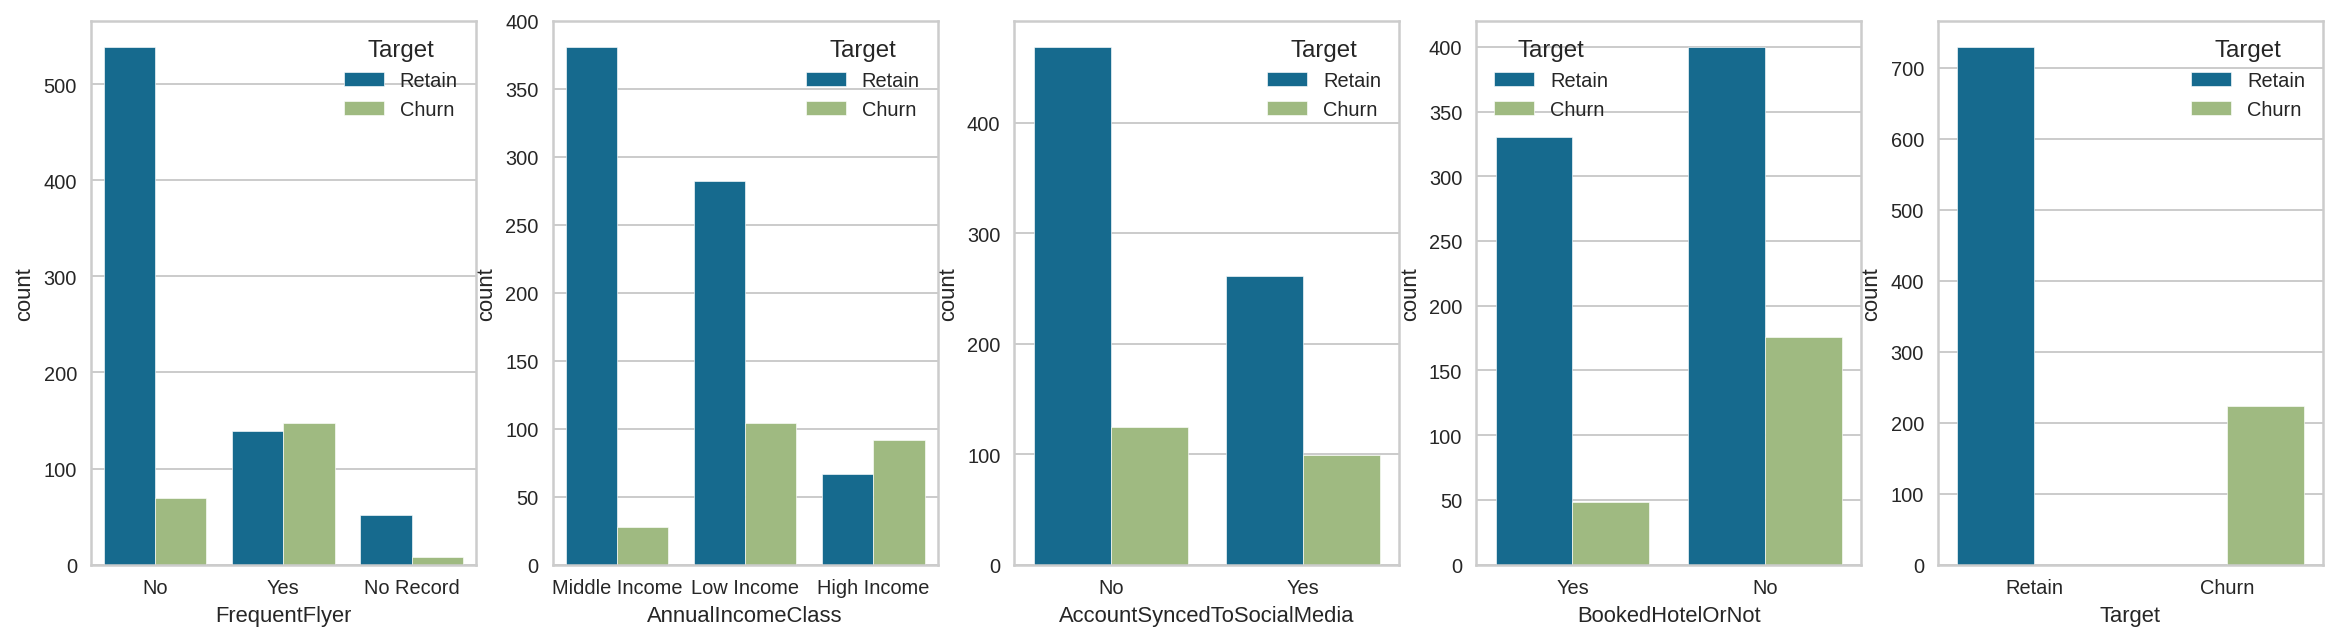

In [19]:
cat_var = data.select_dtypes(include = ['object'])

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for cat, ax in zip(cat_var, axes.flatten()):
	sns.countplot(cat, data=data, hue="Target", ax=ax)

## Numerical Variables vs Churn

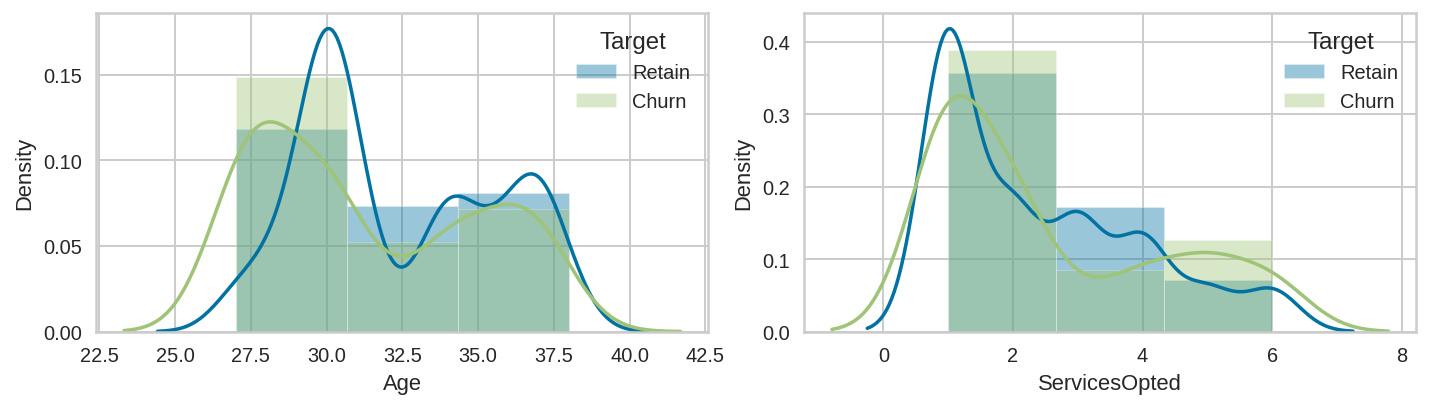

In [20]:
data_grouped = data.groupby(by='Target')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,3))
titles = list(data.select_dtypes(exclude=['object']))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.distplot(data_grouped.get_group('Retain')[title], bins=3, ax=ax,label='Retain')
    sns.distplot(data_grouped.get_group('Churn')[title], bins=3, ax=ax,label='Churn')
    ax.legend(title='Target')

axs.flat[-1].remove()
axs.flat[-2].remove()
fig.tight_layout()

## Box Plots : Outlier Detection

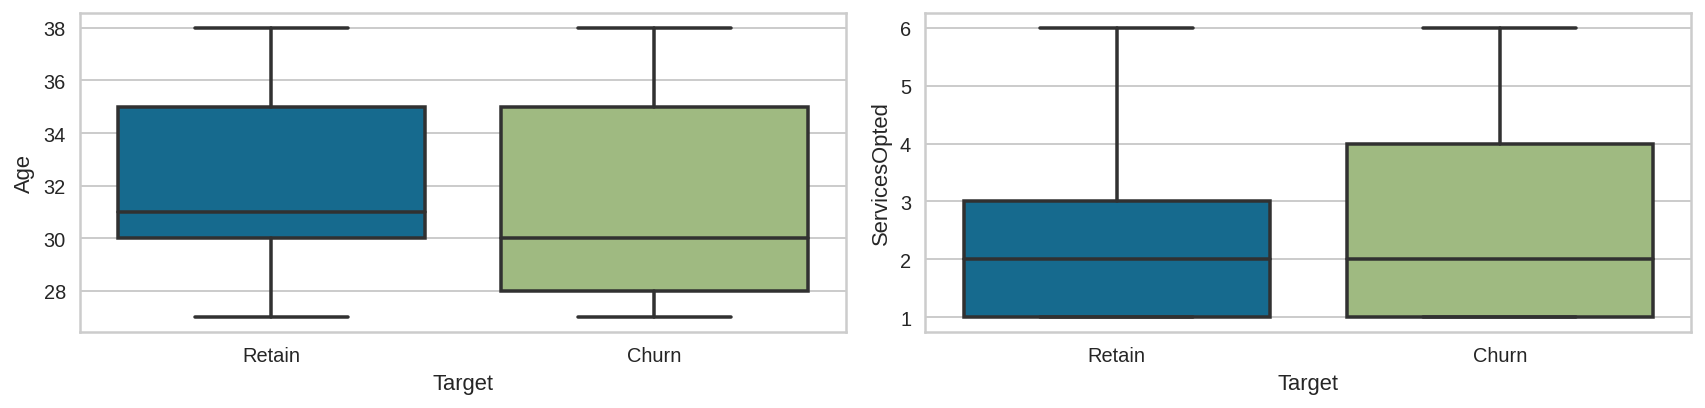

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
titles = data.select_dtypes(exclude=['object'])

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.boxplot(x='Target', y=title, data=data, ax=ax)
fig.tight_layout()

# Data Pre-Processing

## Data Encoding

In [22]:
data['FrequentFlyer'] = data['FrequentFlyer'].replace({'No':0, 'Yes':1, 'No Record':0})
data['AnnualIncomeClass'] = data['AnnualIncomeClass'].replace({'Middle Income':1, 'Low Income':0, 'High Income':2})
data['AccountSyncedToSocialMedia'] = data['AccountSyncedToSocialMedia'].replace({'No':0, 'Yes':1})
data['BookedHotelOrNot'] =data['BookedHotelOrNot'].replace({'No':0, 'Yes':1})
data['Target'] = data['Target'].replace({'Retain':0, 'Churn':1})

In [23]:
data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,0,1,6,0,1,0
1,34,1,0,5,1,0,1
2,37,0,1,3,1,0,0
3,30,0,1,2,0,0,0
4,30,0,0,1,0,0,0
...,...,...,...,...,...,...,...
949,31,1,0,1,0,0,0
950,30,0,1,5,0,1,0
951,37,0,1,4,0,0,0
952,30,0,0,1,1,1,0


## Resampling

In [24]:
# Assign 'TARGET' column to y 
y = data['Target'].values
# Assign all columns except 'TARGET' to X
X = data.drop(['Target'], axis = 1).values

In [25]:
# Check dimension
print('X shape :', X.shape)
print('y shape :', y.shape)

X shape : (954, 6)
y shape : (954,)


In [26]:
# split data to train and test data
# with test size is 20% of overall data
# use stratified sampling
# and set RNG to 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

In [27]:
# Make a new dataframe using train & test data
train_data_x = pd.DataFrame(X_train, columns=data.drop(['Target'], axis = 1).columns)
train_data_y = pd.DataFrame(y_train, columns=['Target'])
train_data = pd.concat([train_data_x, train_data_y], axis=1)

test_data_x = pd.DataFrame(X_test, columns=data.drop(['Target'], axis = 1).columns)
test_data_y = pd.DataFrame(y_test, columns=['Target'])
test_data = pd.concat([test_data_x, test_data_y], axis=1)

In [28]:
train_data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,37,1,0,1,0,0,0
1,34,0,1,2,0,0,0
2,38,1,0,1,0,0,0
3,29,0,1,3,0,0,0
4,37,0,1,1,0,1,0
...,...,...,...,...,...,...,...
758,34,1,2,1,1,0,1
759,36,1,2,1,0,0,1
760,30,0,0,1,1,0,0
761,36,1,2,1,0,0,0


In [29]:
test_data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,30,0,1,3,1,0,0
1,36,1,2,1,0,0,1
2,36,0,0,1,0,1,0
3,29,0,1,2,0,1,0
4,30,1,0,1,1,0,1
...,...,...,...,...,...,...,...
186,34,1,2,1,0,0,0
187,31,1,2,1,0,0,1
188,31,0,1,3,0,0,0
189,34,0,0,4,1,1,0


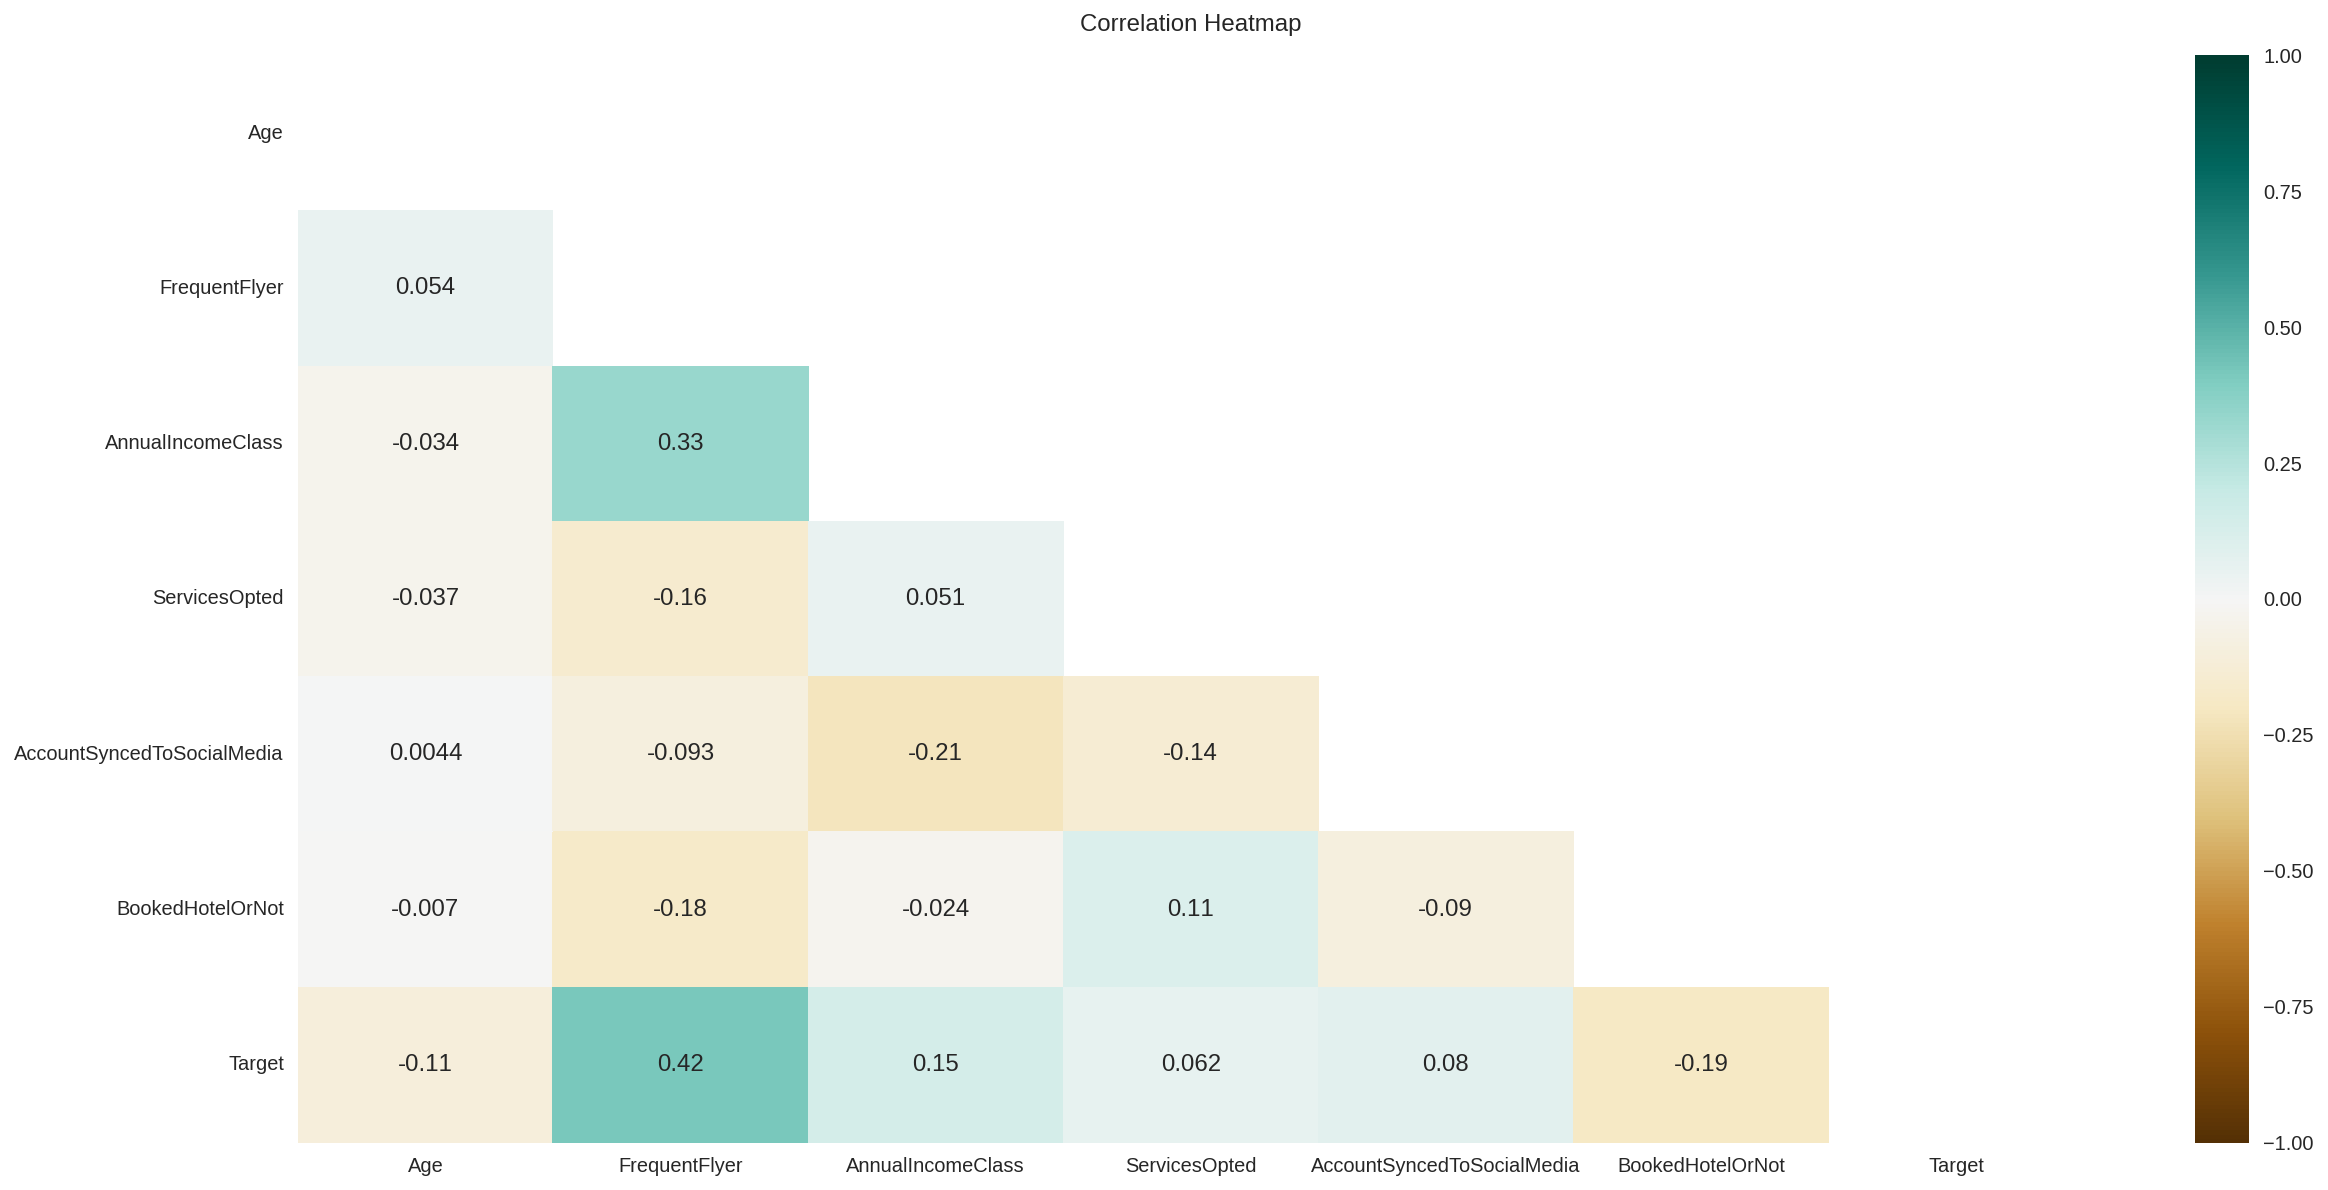

In [30]:
# Increase the size of the heatmap
plt.figure(figsize=(20,10))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(train_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Normalization

In [31]:
# Check train data
train_data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,37,1,0,1,0,0,0
1,34,0,1,2,0,0,0
2,38,1,0,1,0,0,0
3,29,0,1,3,0,0,0
4,37,0,1,1,0,1,0
...,...,...,...,...,...,...,...
758,34,1,2,1,1,0,1
759,36,1,2,1,0,0,1
760,30,0,0,1,1,0,0
761,36,1,2,1,0,0,0


In [32]:
# Check descriptive stats for train data
train_data.describe()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,32.083879,0.307995,0.758847,2.382700,0.382700,0.387942,0.234600
std,3.373245,0.461967,0.727802,1.574173,0.486365,0.487601,0.424027
min,27.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,31.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000
max,38.000000,1.000000,2.000000,6.000000,1.000000,1.000000,1.000000


In [33]:
# Check test data
test_data

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,30,0,1,3,1,0,0
1,36,1,2,1,0,0,1
2,36,0,0,1,0,1,0
3,29,0,1,2,0,1,0
4,30,1,0,1,1,0,1
...,...,...,...,...,...,...,...
186,34,1,2,1,0,0,0
187,31,1,2,1,0,0,1
188,31,0,1,3,0,0,0
189,34,0,0,4,1,1,0


In [34]:
# Check descriptive stats for test data
test_data.describe()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,32.209424,0.267016,0.774869,2.654450,0.356021,0.429319,0.235602
std,3.196728,0.443563,0.677920,1.715554,0.480080,0.496280,0.425490
min,27.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,31.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,1.000000,4.000000,1.000000,1.000000,0.000000
max,38.000000,1.000000,2.000000,6.000000,1.000000,1.000000,1.000000


In [35]:
# Reseparate independent and dependent feature of the train-test data
X_train = train_data.drop(['Target'], axis=1)
y_train = train_data['Target']

X_test = test_data.drop(['Target'], axis=1)
y_test = test_data['Target']

# Data Modeling

## Logistics Regression

In [36]:
# define logistic regression model
logreg = LogisticRegression(solver='liblinear')
# fit model to data
logreg.fit(X_train, y_train)
# fit prediction model to data
y_pred_logreg = logreg.predict(X_test)

In [37]:
logreg

LogisticRegression(solver='liblinear')

## K-Nearest Neighbors

In [38]:
# define k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# fit model to data
knn.fit(X_train, y_train)
# fit prediction model to data
y_pred_knn = knn.predict(X_test)

In [39]:
knn

KNeighborsClassifier(n_neighbors=3)

## Decision Tree

In [40]:
# define decision tree classifier
dtree = DecisionTreeClassifier()
# fit model to data
dtree.fit(X_train, y_train)
# fit prediction model to data
y_pred_dtree = dtree.predict(X_test)

In [41]:
dtree

DecisionTreeClassifier()

## Random Forest

In [42]:
# define Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
# fit model to data
rf.fit(X_train, y_train)
# fit prediction model to data
y_pred_rf = rf.predict(X_test)

In [43]:
rf

RandomForestClassifier()

## XGBoost

In [44]:
# fit model no training data
xgb = XGBClassifier()
# fit model to data
xgb.fit(X_train, y_train)
# fit prediction model to data
y_pred_xgb = xgb.predict(X_test)

In [45]:
xgb

XGBClassifier()

## Modeling Comparasion

In [46]:
models = []
models.append(("Logistic Regression",LogisticRegression(solver='liblinear')))
models.append(("Random Forest",RandomForestClassifier(n_estimators=100)))
models.append(("XGBoost",XGBClassifier()))
models.append(("KNN",KNeighborsClassifier(n_neighbors = 3)))
models.append(("Decision Tree",DecisionTreeClassifier()))

In [47]:
from sklearn import model_selection
recall_results = []
precision_results = []
auc_results = []
f1_score = []
names = []
col = ['ML Mode','ROC-AUC','ROC-AUC Std','Recall','Recall Std','Precision','Precision Std','F1-Score','F1-Score Std']

df_results = pd.DataFrame(columns=col)

i = 0

c = list(set(X_train.columns))

for name,model in models:
    kfold = model_selection.KFold(n_splits=3)
    cv_recall_results = model_selection.cross_val_score(model,X_train[c],y_train,cv=kfold,scoring="recall")
    
    cv_precision_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                        cv=kfold,scoring="precision")
    
    cv_auc_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                   cv=kfold,scoring="roc_auc")
    
    cv_f1_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                   cv=kfold,scoring="f1")
    recall_results.append(cv_recall_results)
    precision_results.append(cv_precision_results)
    auc_results.append(cv_auc_results)
    f1_score.append(cv_f1_results)
    names.append(name)

    df_results.loc[i] = [name,
                        round(cv_auc_results.mean()*100,2),
                        round(cv_auc_results.std()*100,2),
                        round(cv_recall_results.mean()*100,2),
                        round(cv_recall_results.std()*100,2),
                        round(cv_precision_results.mean()*100,2),
                        round(cv_precision_results.std()*100,2),
                        round(cv_f1_results.mean()*100,2),
                        round(cv_f1_results.std()*100,2)]
    i += 1

In [48]:
df_results.sort_values('F1-Score',ascending=False)

,ML Mode,ROC-AUC,ROC-AUC Std,Recall,Recall Std,Precision,Precision Std,F1-Score,F1-Score Std
4,Decision Tree,89.18,2.83,74.53,6.85,77.79,2.65,75.50,2.52
1,Random Forest,94.10,0.95,68.21,5.95,74.03,4.87,73.45,1.38
2,XGBoost,94.91,0.53,69.13,7.87,76.32,6.84,71.82,1.25
3,KNN,84.04,2.87,52.07,10.07,72.99,7.85,59.45,3.87
0,Logistic Regression,81.48,1.00,37.86,17.31,60.69,2.70,43.48,14.88


# Model Evaluation

In [49]:
# Logistics Regression Prediction
lr_pred = logreg.predict(X_test)
lr_pred_proba = logreg.predict_proba(X_test)

# KNN Prediction
knn_pred = knn.predict(X_test)
knn_pred_proba = knn.predict_proba(X_test)

# Decision Tree Prediction
dtree_pred = dtree.predict(X_test)
dtree_pred_proba = dtree.predict_proba(X_test)

# Random Forest Prediction
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)

# XGBoost Prediction
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)

### Classification Report

In [50]:
# Logistics Regression Prediction Result
pd.DataFrame(metrics.classification_report(y_test, lr_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.844311,0.791667,0.837696,0.817989,0.831908
recall,0.965753,0.422222,0.837696,0.693988,0.837696
f1-score,0.900958,0.550725,0.837696,0.725842,0.818443
support,146.000000,45.000000,0.837696,191.000000,191.000000


In [51]:
# KNN prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.863354,0.766667,0.848168,0.815010,0.840574
recall,0.952055,0.511111,0.848168,0.731583,0.848168
f1-score,0.905537,0.613333,0.848168,0.759435,0.836694
support,146.000000,45.000000,0.848168,191.000000,191.000000


In [52]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.926667,0.829268,0.905759,0.877967,0.903719
recall,0.952055,0.755556,0.905759,0.853805,0.905759
f1-score,0.939189,0.790698,0.905759,0.864943,0.904204
support,146.000000,45.000000,0.905759,191.000000,191.000000


In [53]:
# random forest prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.908497,0.815789,0.890052,0.862143,0.886655
recall,0.952055,0.688889,0.890052,0.820472,0.890052
f1-score,0.929766,0.746988,0.890052,0.838377,0.886703
support,146.000000,45.000000,0.890052,191.000000,191.000000


In [54]:
# XGBoost prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.903846,0.857143,0.895288,0.880495,0.892843
recall,0.965753,0.666667,0.895288,0.816210,0.895288
f1-score,0.933775,0.750000,0.895288,0.841887,0.890477
support,146.000000,45.000000,0.895288,191.000000,191.000000


### Confusion Matrix

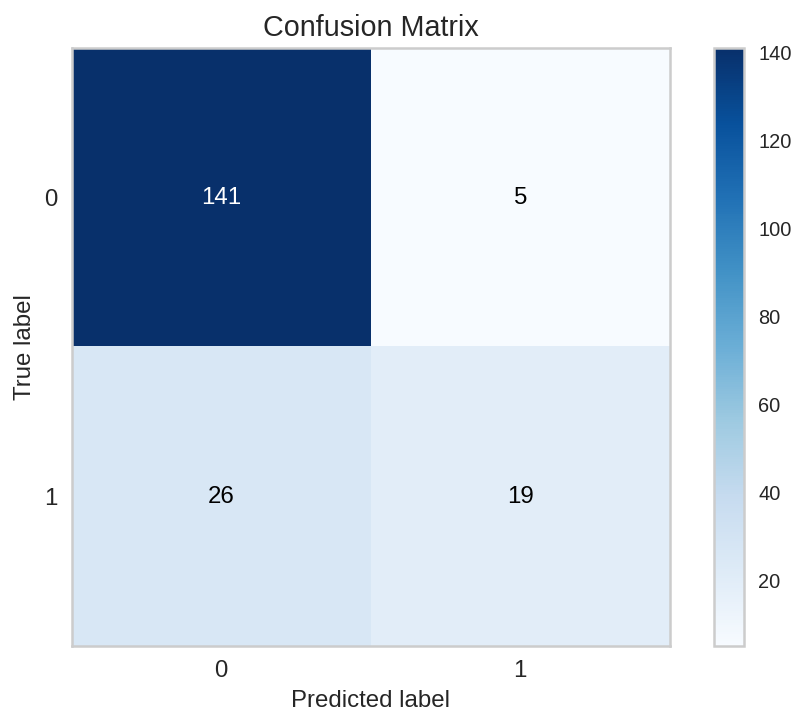

In [55]:
# Logistic Regression result
skplt.metrics.plot_confusion_matrix(y_test, lr_pred);

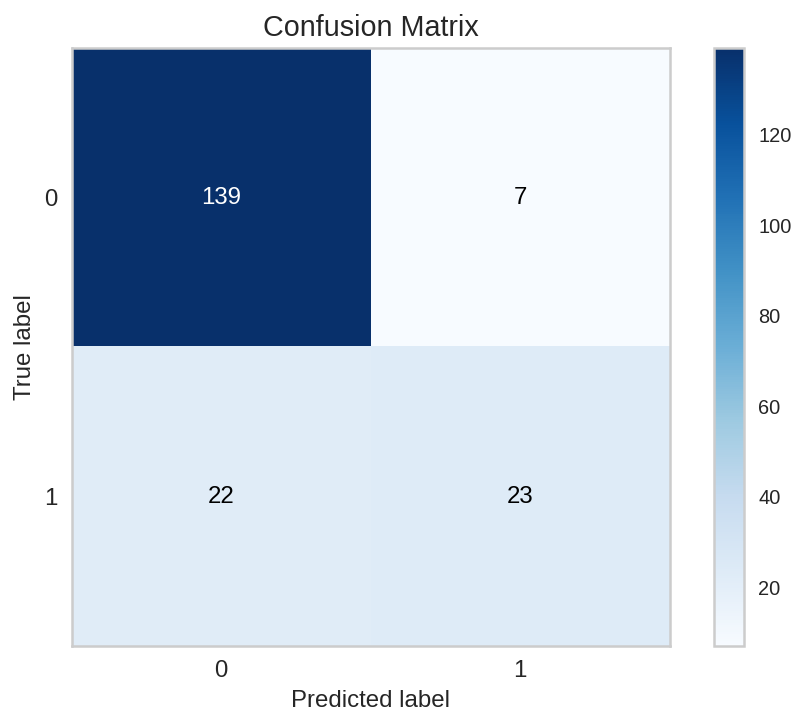

In [56]:
# KNN result
skplt.metrics.plot_confusion_matrix(y_test, knn_pred);

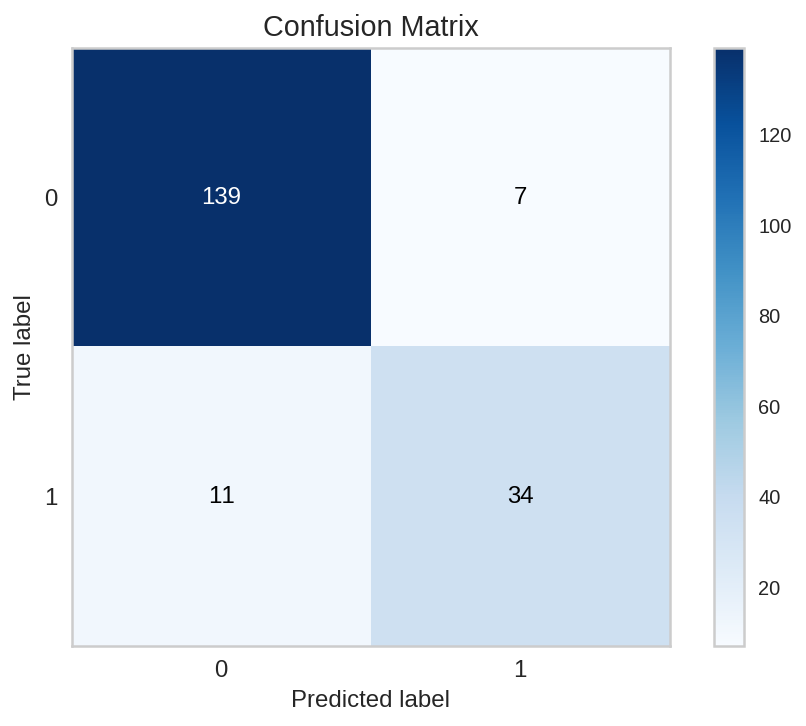

In [57]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, dtree_pred);

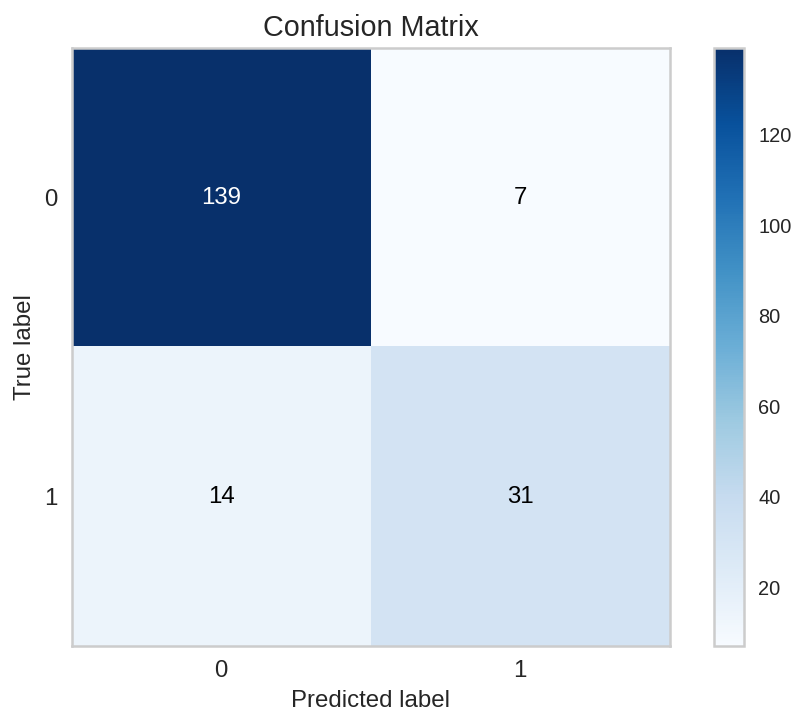

In [58]:
# random forest result
skplt.metrics.plot_confusion_matrix(y_test, rf_pred);

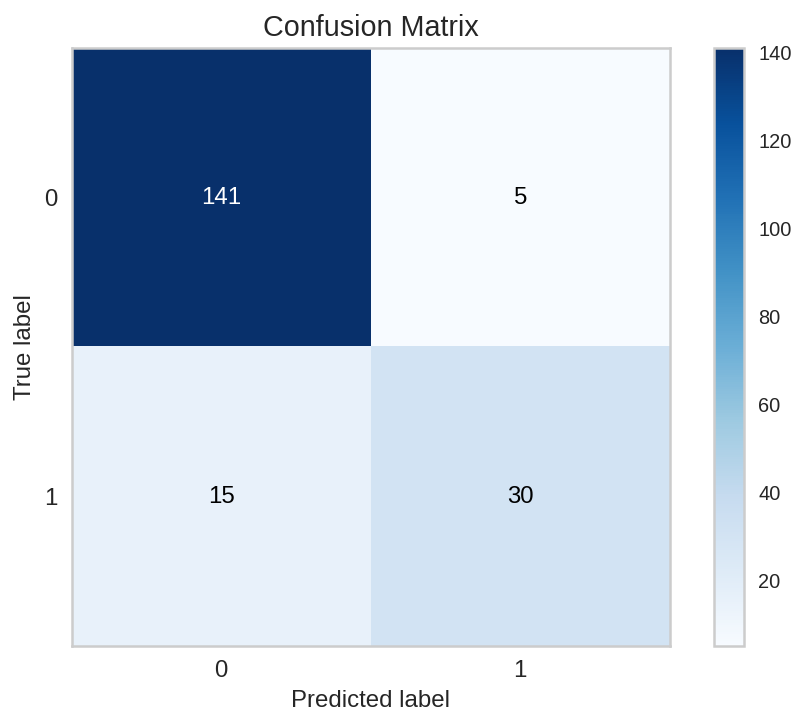

In [59]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, xgb_pred);

### ROC-AUC

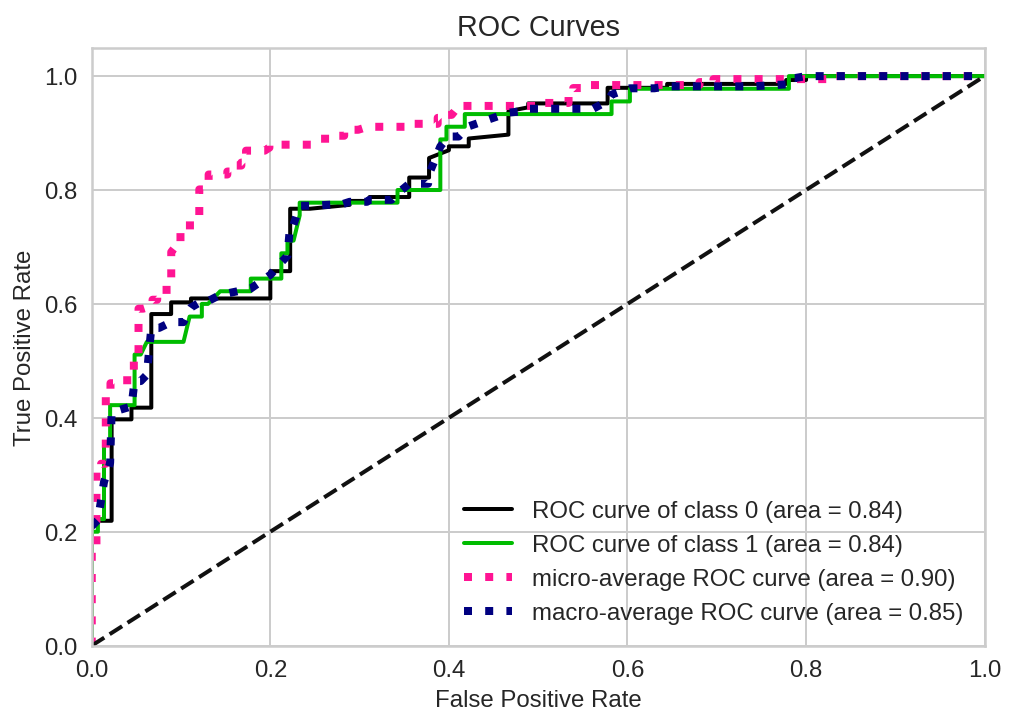

In [60]:
# Log result
skplt.metrics.plot_roc_curve(y_test, lr_pred_proba);

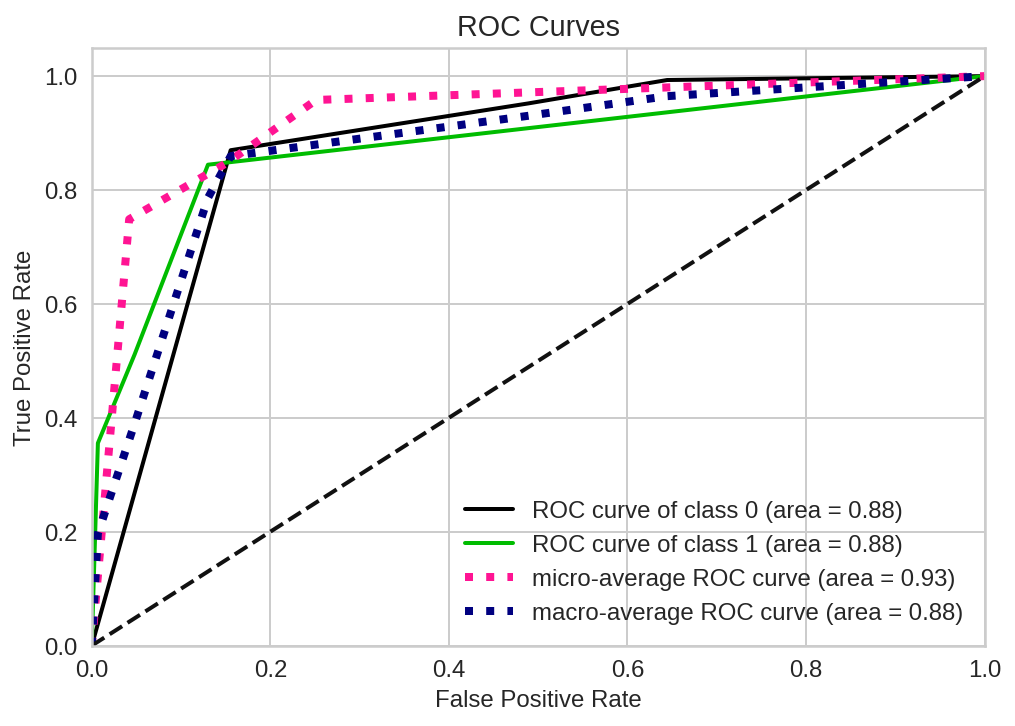

In [61]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba);

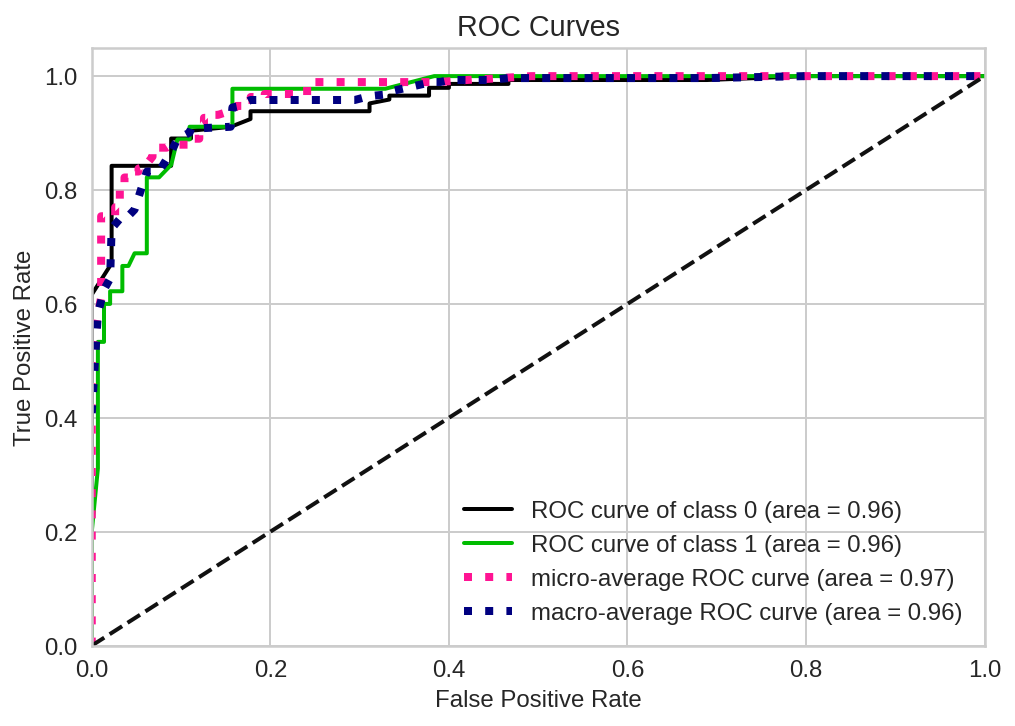

In [62]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba);

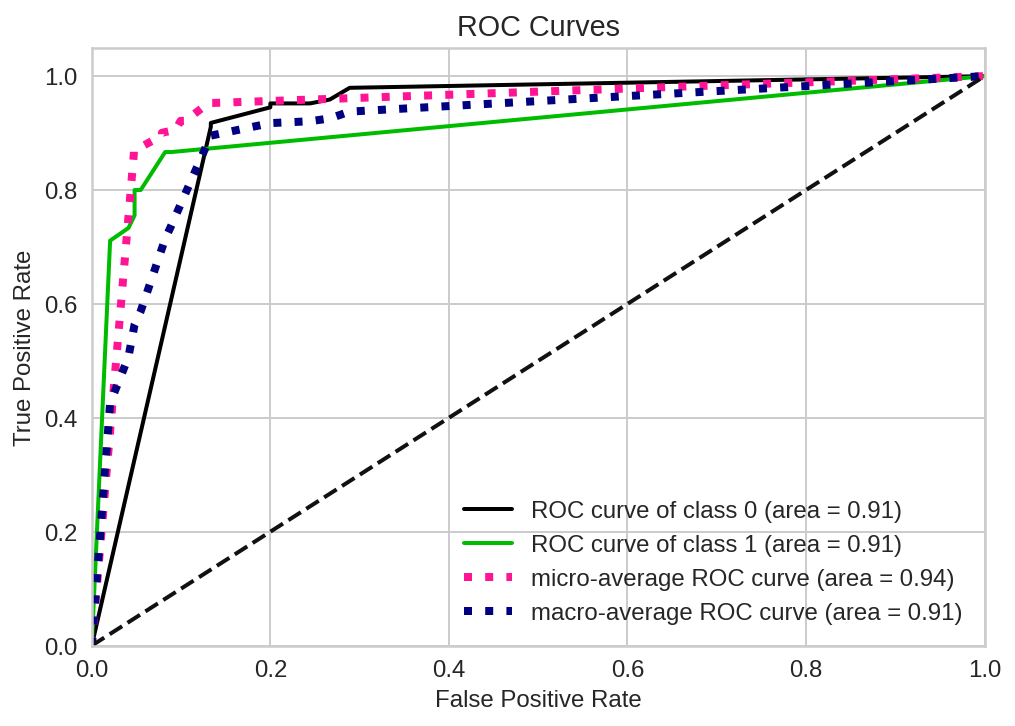

In [63]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba);

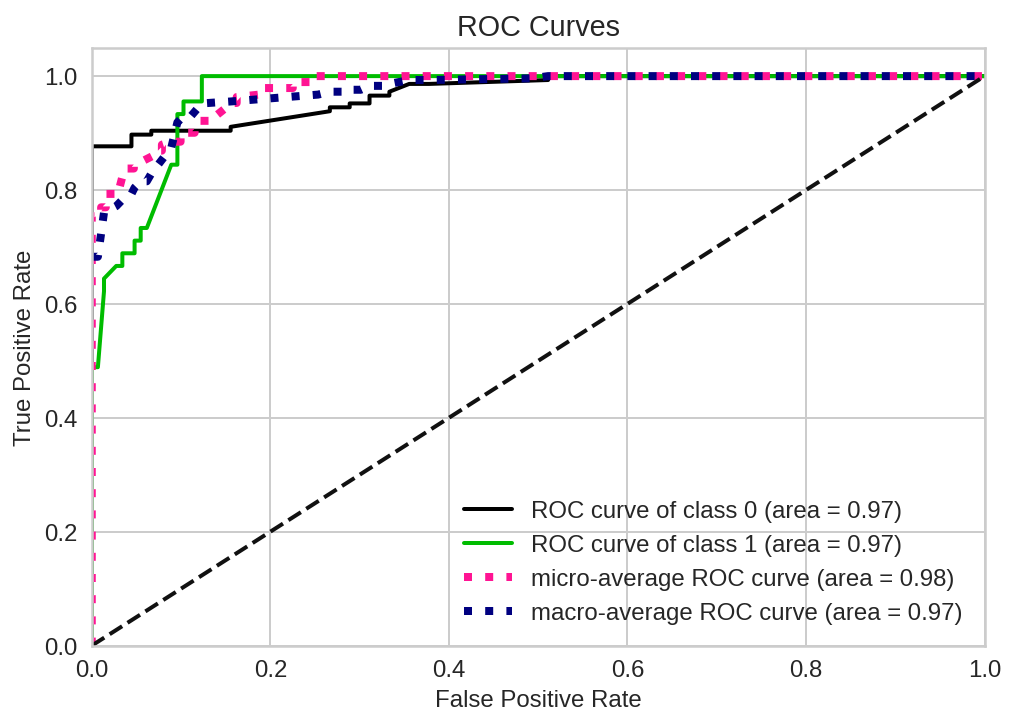

In [64]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba);

### AOC Score

In [65]:
# check LogReg f1-score
metrics.roc_auc_score(y_test, lr_pred)

0.6939878234398783

In [66]:
# check KNN f1-score
metrics.roc_auc_score(y_test, knn_pred)

0.7315829528158295

In [67]:
# check Decision Tree f1-score
metrics.roc_auc_score(y_test, dtree_pred)

0.8538051750380518

In [68]:
# check Random Forest f1-score
metrics.roc_auc_score(y_test, rf_pred)

0.8204718417047185

In [69]:
# check XGBoost f1-score
metrics.roc_auc_score(y_test, xgb_pred)

0.8162100456621003

### Precision

In [70]:
# check LogReg f1-score
metrics.precision_score(y_test, lr_pred)

0.7916666666666666

In [71]:
# check KNN f1-score
metrics.precision_score(y_test, knn_pred)

0.7666666666666667

In [72]:
# check Decision Tree f1-score
metrics.precision_score(y_test, dtree_pred)

0.8292682926829268

In [73]:
# check Random Forest f1-score
metrics.precision_score(y_test, rf_pred)

0.8157894736842105

In [74]:
# check XGBoost f1-score
metrics.precision_score(y_test, xgb_pred)

0.8571428571428571

### Recall

In [75]:
# check LogReg f1-score
metrics.recall_score(y_test, lr_pred)

0.4222222222222222

In [76]:
# check KNN f1-score
metrics.recall_score(y_test, knn_pred)

0.5111111111111111

In [77]:
# check Decision Tree f1-score
metrics.recall_score(y_test, dtree_pred)

0.7555555555555555

In [78]:
# check Random Forest f1-score
metrics.recall_score(y_test, rf_pred)

0.6888888888888889

In [79]:
# check XGBoost f1-score
metrics.recall_score(y_test, xgb_pred)

0.6666666666666666

### F1-Score

In [80]:
# check LogReg f1-score
metrics.f1_score(y_test, lr_pred)

0.5507246376811594

In [81]:
# check KNN f1-score
metrics.f1_score(y_test, knn_pred)

0.6133333333333334

In [82]:
# check Decision Tree f1-score
metrics.f1_score(y_test, dtree_pred)

0.7906976744186047

In [83]:
# check Random Forest f1-score
metrics.f1_score(y_test, rf_pred)

0.746987951807229

In [84]:
# check XGBoost f1-score
metrics.f1_score(y_test, xgb_pred)

0.75

# Imbalanced Modelling using G-Means

## Logistic Regression

In [85]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.19800783497711924, G-Mean=0.7724321626955434


### New Prediction

In [86]:
# change predict proba result to optimized one using new threshold
new_pred_result = (lr_pred_proba[:,1] >= thresholds[ix]).astype(int)

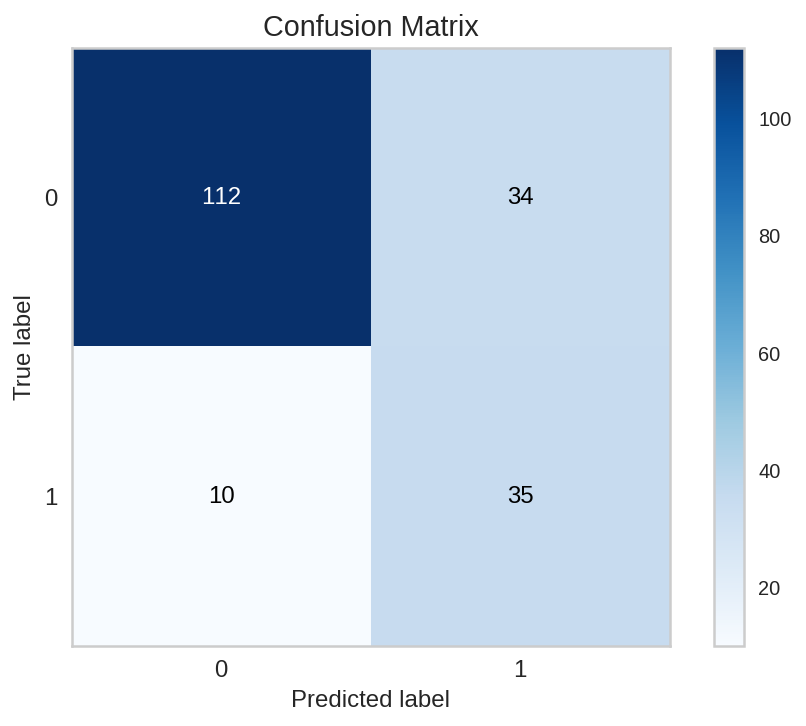

In [87]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [88]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.7724505327245053

In [89]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.5072463768115942

In [90]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7777777777777778

In [91]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.6140350877192984

In [92]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.918033,0.507246,0.769634,0.712640,0.821251
recall,0.767123,0.777778,0.769634,0.772451,0.769634
f1-score,0.835821,0.614035,0.769634,0.724928,0.783568
support,146.000000,45.000000,0.769634,191.000000,191.000000


### Old Prediction

In [93]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, lr_pred)

0.6939878234398783

In [94]:
# check old precision
metrics.precision_score(y_test, lr_pred)

0.7916666666666666

In [95]:
# check old recall
metrics.recall_score(y_test, lr_pred)

0.4222222222222222

In [96]:
# compare to the old f1 score
metrics.f1_score(y_test, lr_pred)

0.5507246376811594

In [97]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, lr_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.844311,0.791667,0.837696,0.817989,0.831908
recall,0.965753,0.422222,0.837696,0.693988,0.837696
f1-score,0.900958,0.550725,0.837696,0.725842,0.818443
support,146.000000,45.000000,0.837696,191.000000,191.000000


## K-Nearest Neighbors

In [98]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.3333333333333333, G-Mean=0.8570595016365607


### New Prediction

In [99]:
# change predict proba result to optimized one using new threshold
new_pred_result = (knn_pred_proba[:,1] >= thresholds[ix]).astype(int)

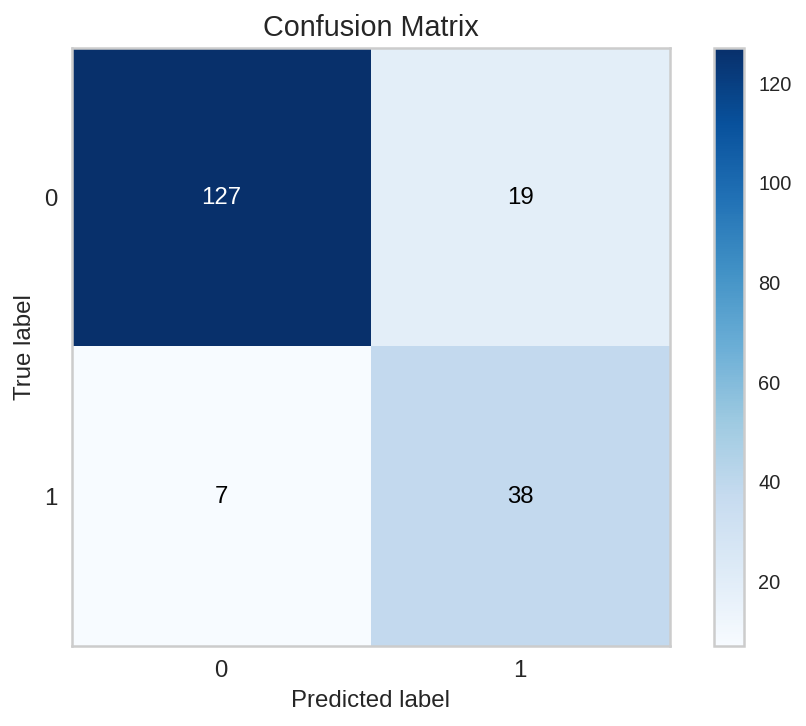

In [100]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [101]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.8571537290715374

In [102]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.6666666666666666

In [103]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.8444444444444444

In [104]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.7450980392156862

In [105]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.947761,0.666667,0.863874,0.807214,0.881535
recall,0.869863,0.844444,0.863874,0.857154,0.863874
f1-score,0.907143,0.745098,0.863874,0.826120,0.868965
support,146.000000,45.000000,0.863874,191.000000,191.000000


### Old Prediction

In [106]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, lr_pred)

0.6939878234398783

In [107]:
# check old precision
metrics.precision_score(y_test, knn_pred)

0.7666666666666667

In [108]:
# check old recall
metrics.recall_score(y_test, knn_pred)

0.5111111111111111

In [109]:
# compare to the old f1 score
metrics.f1_score(y_test, knn_pred)

0.6133333333333334

In [110]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.863354,0.766667,0.848168,0.815010,0.840574
recall,0.952055,0.511111,0.848168,0.731583,0.848168
f1-score,0.905537,0.613333,0.848168,0.759435,0.836694
support,146.000000,45.000000,0.848168,191.000000,191.000000


## Decision Tree

In [111]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, dtree_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.3333333333333333, G-Mean=0.8918709491593152


In [112]:
# change predict proba result to optimized one using new threshold
new_pred_result = (dtree_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

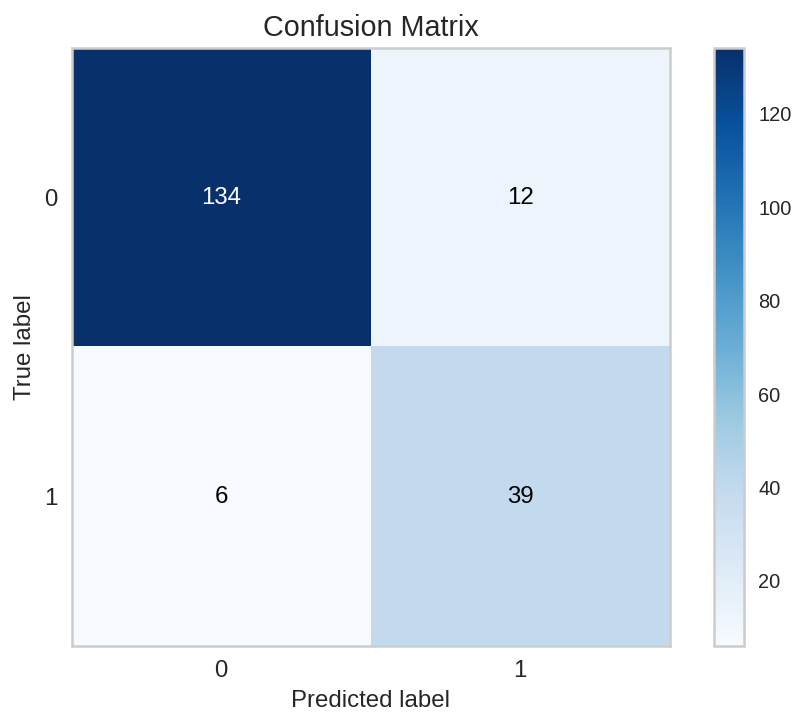

In [113]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [114]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.8922374429223744

In [115]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.7647058823529411

In [116]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.8666666666666667

In [117]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.8125

In [118]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.957143,0.764706,0.905759,0.860924,0.911804
recall,0.917808,0.866667,0.905759,0.892237,0.905759
f1-score,0.937063,0.812500,0.905759,0.874781,0.907716
support,146.000000,45.000000,0.905759,191.000000,191.000000


### Old Prediction

In [119]:
# check old f1-score
metrics.roc_auc_score(y_test, dtree_pred)

0.8538051750380518

In [120]:
# check old precision
metrics.precision_score(y_test, dtree_pred)

0.8292682926829268

In [121]:
# check old recall
metrics.recall_score(y_test, dtree_pred)

0.7555555555555555

In [122]:
# compare to the old f1 score
metrics.f1_score(y_test, dtree_pred)

0.7906976744186047

In [123]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.926667,0.829268,0.905759,0.877967,0.903719
recall,0.952055,0.755556,0.905759,0.853805,0.905759
f1-score,0.939189,0.790698,0.905759,0.864943,0.904204
support,146.000000,45.000000,0.905759,191.000000,191.000000


## Random Forest

In [124]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.07408447108447108, G-Mean=0.9076035986252164


In [125]:
# change predict proba result to optimized one using new threshold
new_pred_result = (rf_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

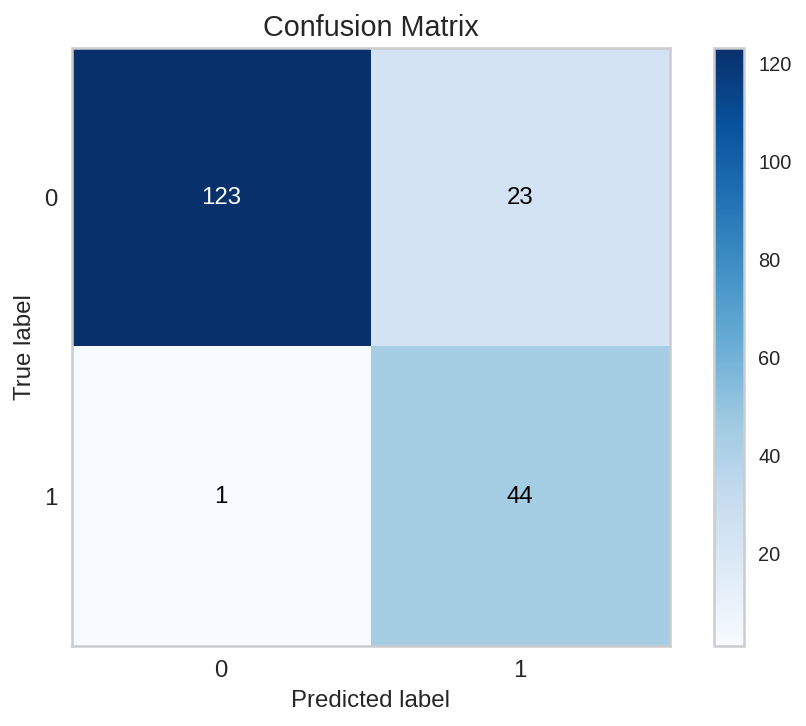

In [126]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [127]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.9101217656012177

In [128]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.6567164179104478

In [129]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.9777777777777777

In [130]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.7857142857142858

In [131]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.991935,0.656716,0.874346,0.824326,0.912957
recall,0.842466,0.977778,0.874346,0.910122,0.874346
f1-score,0.911111,0.785714,0.874346,0.848413,0.881567
support,146.000000,45.000000,0.874346,191.000000,191.000000


### Old Prediction

In [132]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, rf_pred)

0.8204718417047185

In [133]:
# check old precision
metrics.precision_score(y_test, rf_pred)

0.8157894736842105

In [134]:
# check old recall
metrics.recall_score(y_test, rf_pred)

0.6888888888888889

In [135]:
# compare to the old f1 score
metrics.f1_score(y_test, rf_pred)

0.746987951807229

In [136]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.908497,0.815789,0.890052,0.862143,0.886655
recall,0.952055,0.688889,0.890052,0.820472,0.890052
f1-score,0.929766,0.746988,0.890052,0.838377,0.886703
support,146.000000,45.000000,0.890052,191.000000,191.000000


## XGBoost

In [137]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.13987207412719727, G-Mean=0.9363291775690444


In [138]:
# change predict proba result to optimized one using new threshold
new_pred_result = (xgb_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

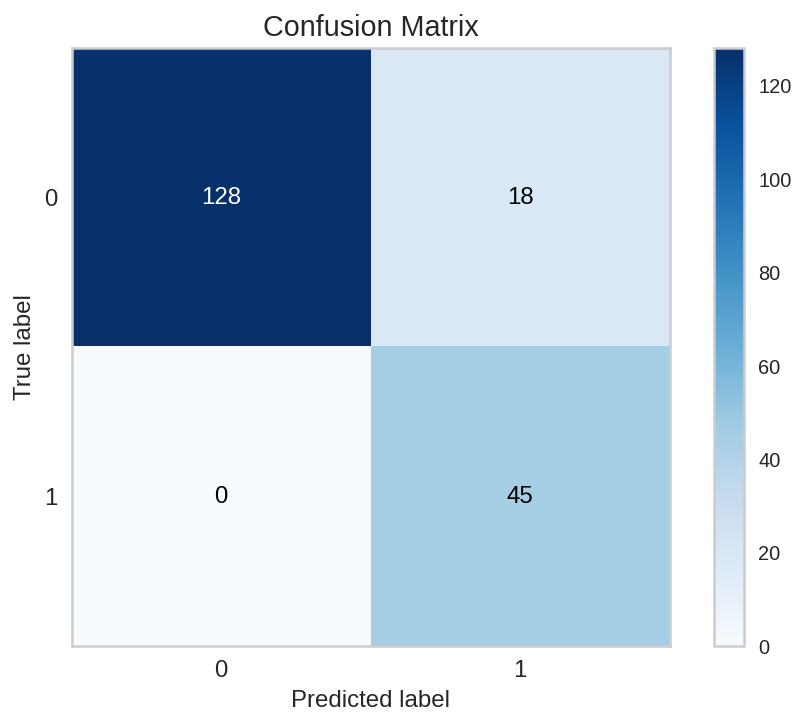

In [139]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [140]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.9383561643835616

In [141]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.7142857142857143

In [142]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

1.0

In [143]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.8333333333333333

In [144]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.714286,0.905759,0.857143,0.932685
recall,0.876712,1.000000,0.905759,0.938356,0.905759
f1-score,0.934307,0.833333,0.905759,0.883820,0.910517
support,146.000000,45.000000,0.905759,191.000000,191.000000


### Old Prediction

In [145]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, xgb_pred)

0.8162100456621003

In [146]:
# check old precision
metrics.precision_score(y_test, xgb_pred)

0.8571428571428571

In [147]:
# check old recall
metrics.recall_score(y_test, xgb_pred)

0.6666666666666666

In [148]:
# compare to the old f1 score
metrics.f1_score(y_test, xgb_pred)

0.75

In [149]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.903846,0.857143,0.895288,0.880495,0.892843
recall,0.965753,0.666667,0.895288,0.816210,0.895288
f1-score,0.933775,0.750000,0.895288,0.841887,0.890477
support,146.000000,45.000000,0.895288,191.000000,191.000000


# Agnostics Model

### Variable Importance - Partial Dependence Plot

In [150]:
## initiate explainer for the best model
churn_exp = dx.Explainer(dtree, X_train, y_train, label = "Decision Tree Interpretation")

Preparation of a new explainer is initiated

  -> data              : 763 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 763 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Decision Tree Interpretation
  -> predict function  : <function yhat_proba_default at 0x7f3898ae1a70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.235, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.667, mean = 3.49e-18, max = 0.8
  -> model_info        : package sklearn

A new explainer has been created!


In [162]:
# visualize permutation feature importance for the best model
churn_exp.model_parts().plot()

In [152]:
# create partial dependence plot of XGBoost model
churn_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 6/6 [00:00<00:00, 114.08it/s]


# Business Evaluation Metrics

### Gain Cumulative Curve

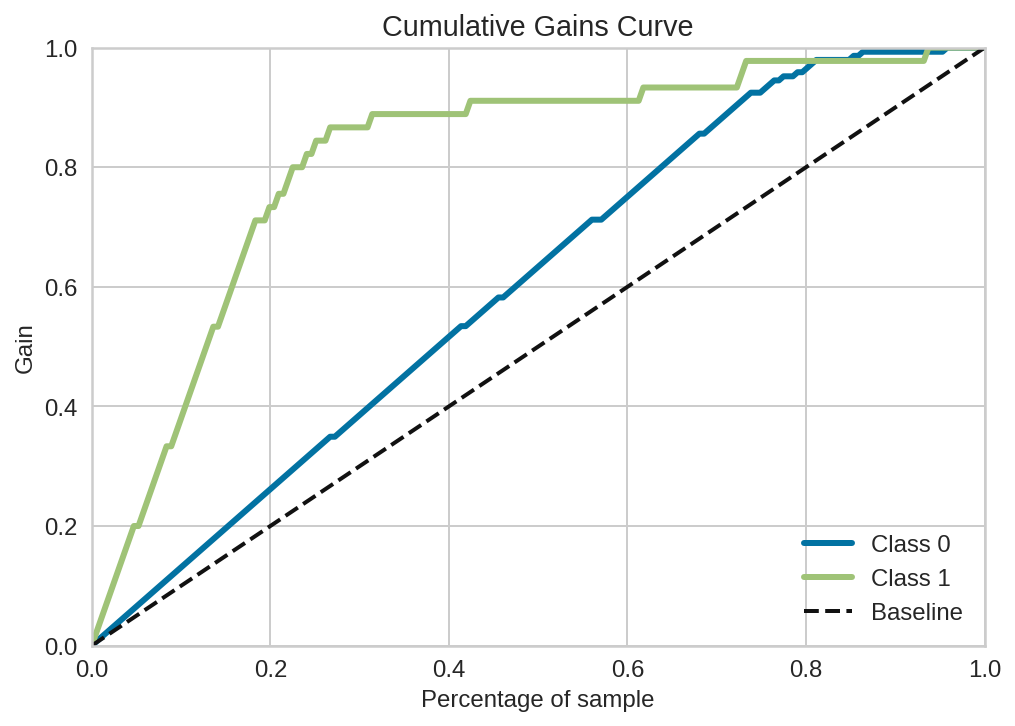

In [153]:
skplt.metrics.plot_cumulative_gain(y_test, dtree_pred_proba)

### Lift Curve

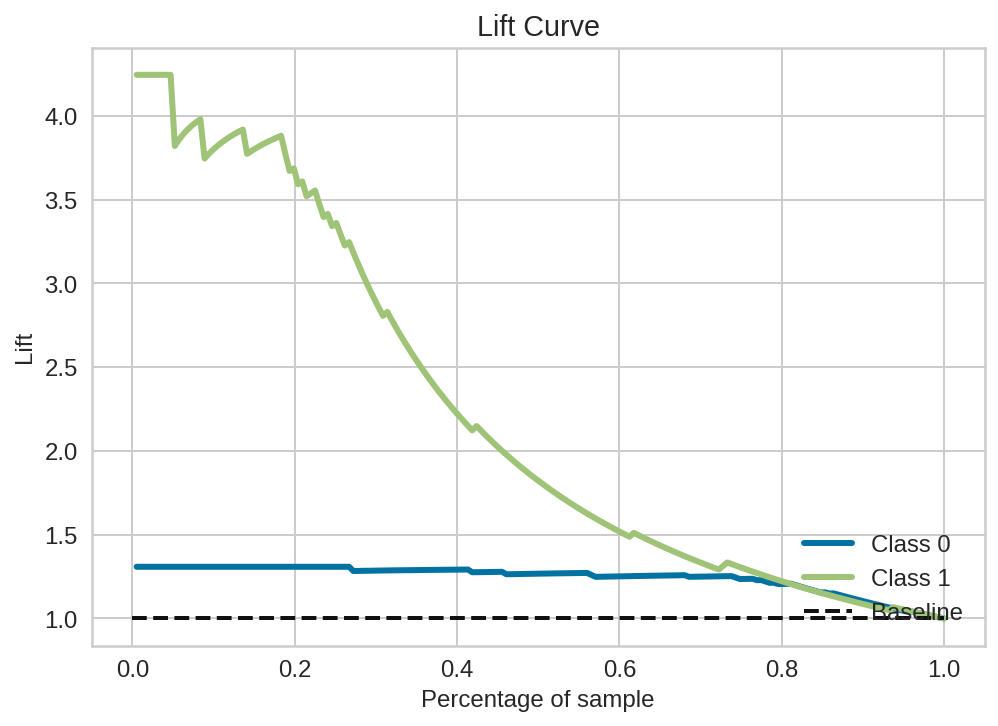

In [154]:
skplt.metrics.plot_lift_curve(y_test, dtree_pred_proba)

### Profit Curve

In [155]:
def standard_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def plot_profit_curve(model_object, costbenefit_mat, y_proba, y_test):
    '''
    Plot profit curve.

    INPUTS:
    - model object
    - cost benefit matrix in the same format as the confusion matrix above
    - predicted probabilities
    - actual labels
    '''

    # Profit curve data
    profits = [] # one profit value for each T (threshold)
    thresholds = sorted(y_proba, reverse=True)

    # For each threshold, calculate profit - starting with largest threshold
    for T in thresholds:
        y_pred = (y_proba > T).astype(int)
        confusion_mat = metrics.confusion_matrix(y_test, y_pred)
        # Calculate total profit for this threshold
        profit = sum(sum(confusion_mat * costbenefit_mat)) / len(y_test)
        profits.append(profit)

    print(profits)
    # Profit curve plot
    model_name = model_object.__class__.__name__
    max_profit = max(profits)
    plt.plot(np.linspace(0, 1, len(y_test)), profits, label = '{}, max profit ${:.2f} per user'.format(model_name, max_profit))


In [156]:
# create cost benefit matrix
costbenefit_mat = np.array([[0, -10000],
                            [0, 30000 - 10000]])

In [157]:
# check cost benefit matrix
costbenefit_mat

array([[     0, -10000],
       [     0,  20000]])

In [158]:
# check model confusion matrix
metrics.confusion_matrix(y_test, dtree_pred)

array([[139,   7],
       [ 11,  34]])

In [159]:
# The Best Model
dtree = DecisionTreeClassifier()

# The Best Model Parameters
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# define model with GridSearchCV
grid_search = GridSearchCV(
    estimator=dtree, 
    param_grid=params, 
    n_jobs=1, 
    verbose=1,
    cv = 5,
    scoring = "f1"
)

# fitting gridsearch
grid_search.fit(X_train, y_train)

# check the best estimator
grid_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5)

In [160]:
# assign the best estimator to new variable
tree_best = grid_search.best_estimator_

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3193.717277486911, 3193.717277486911, 3193.717277486911, 3193.717277486911, 3141.361256544503, 3141.361256544503, 3193.717277486911, 3193.717277486911, 3403.1413612565443, 3350.785340314136, 3350.785340314136, 3350.785340314136, 3350.785340314136, 3350.785340314136, 3350.785340314136, 3350.785340314136, 3455.497382198953, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 3403.1413612565443, 

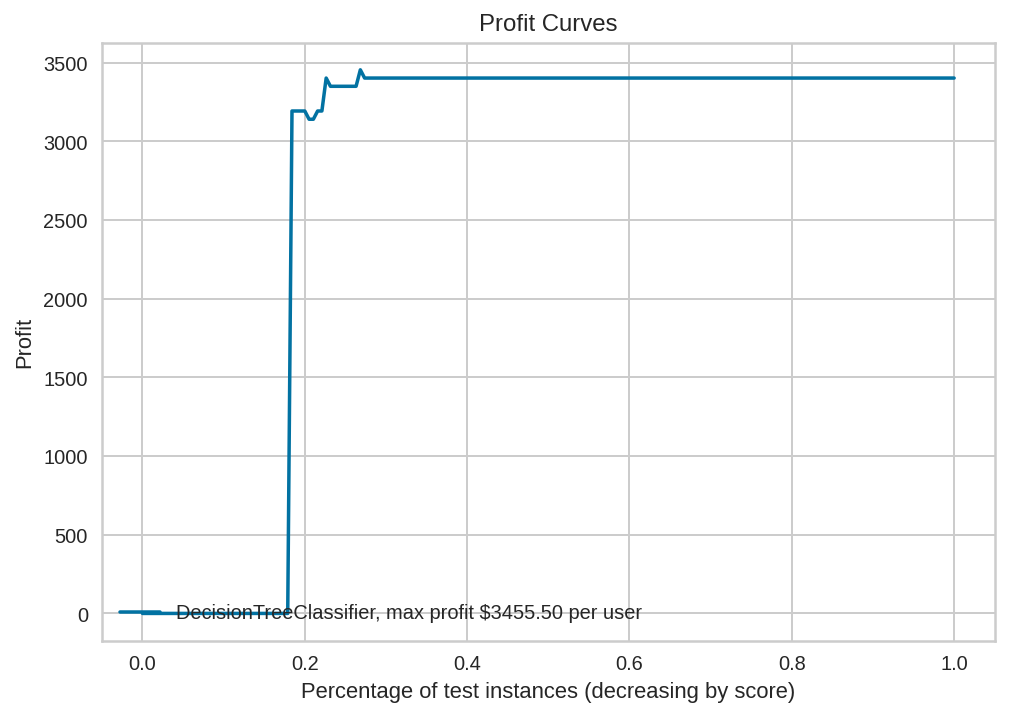

In [161]:
plot_profit_curve(tree_best,costbenefit_mat, dtree_pred_proba[:,1], y_test)
plt.xlabel('Percentage of test instances (decreasing by score)')
plt.ylabel('Profit')
plt.title('Profit Curves')
plt.legend(loc='lower left')
plt.show()